<a href="https://colab.research.google.com/github/ashikshafi08/Learning-Fastai/blob/main/Chapters%20Notebooks/Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Chapter - 5 (Fastai Book)**

# Image Classification 



In [1]:
# Run once

!pip install fastai --upgrade

     |████████████████████████████████| 194kB 7.6MB/s 
     |████████████████████████████████| 61kB 7.3MB/s 
  Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61


In [2]:
# Certain utils

!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
from fastbook import *

# Needed packages

from fastai import *
from fastai.vision.all import *

     |████████████████████████████████| 727kB 8.7MB/s 
     |████████████████████████████████| 1.2MB 50.9MB/s 
     |████████████████████████████████| 51kB 7.2MB/s 
Mounted at /content/gdrive


As in previous lectures we peeked under the hood, but the important thing is to make our model perform really well we have to keep an eye out for lot of details. 

This process requires being able to look inside the neural network as it trains and as it make predictions, find possible problems and know how to fix them

From now on will dive deep into mechanics of deep learning, things like: 
- Architecture of computer vision model , NLP , tabular model.
- how to create arch that matches the needs of our particular domain.
- how to get the best possible results from the training process.
- and how to make things faster
- what changes we gotta make as the datasets change etc...

Going to make the basic application looked earlier in the Chapter 1, but will do 2 things to that : 

- Make them better
- Apply them to a wider variety of types of data

Well to work out these 2 things, we gotta learn the pieces of deep learning puzzle, which includes:

- Types of layers
- Regularization methods
- optimizers
- how to put layers together into architectures
- labelling techniques etc...

## **From Dogs and Cats to Pet Breeds**

But in Chapter 1 we discussed about Dog v/s Cat which was easy enough to work on, but it seems this `PETs` dataset is more complex than what we did in the Chapter 1. Where now will dive deep to figure out what breed of pet is shown in each image.

In practical things will be more different like, 

- we start with a dataset we know nothing about
- figure out how it is put together
- how to extract the data we needed from it
- and what the data looks like

In [3]:
# Getting the data 
path = untar_data(URLs.PETS)

To get those breeds out of the data, firstly we gotta understand how this data is laid out. Such details of data layout are a vital piece of deep learning puzzle. 

Data is usually provided in one of these 2 ways: 

- Individual files representing items of data, such as text docs or images which are **organized into folders or with filenames** representing info about those items.
- A table of data (e.g CSV format) in which **each row is an item** and may include **filenames providing connections data in the table and data in other formats**, such as text or images.

But there are exceptions to these above rules, in domains like genomic, where there will be a **binary database or even network streams** but overall the vast majority of datasets will be in the **combinations of the above 2 rules**.

In [4]:
# To see what's in our dataset 

path.ls()

(#2) [Path('/root/.fastai/data/oxford-iiit-pet/annotations'),Path('/root/.fastai/data/oxford-iiit-pet/images')]

Well this dataset provides us with `images` and `annotations`, the **annotation library** --> contains information where the pets are. 


* **classification** --> what the pets are 
* **localization** --> where the pets are 

In this chapter will work on **classification** and ignore the annotations directory for now. 

In [5]:
# Looking into the image directory 

(path /'images').ls()

(#7393) [Path('/root/.fastai/data/oxford-iiit-pet/images/Egyptian_Mau_193.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/British_Shorthair_87.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/scottish_terrier_50.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/Birman_110.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/saint_bernard_117.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/havanese_179.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/american_pit_bull_terrier_179.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/basset_hound_198.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/staffordshire_bull_terrier_174.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/staffordshire_bull_terrier_54.jpg')...]

Most functions and methods in **fastai** that returns a collection (like above) use a *class* called `L` .

Yet this is an enhanced version of the ordinary Python `list` type, for instance when we display a object of this class in a notebook. It appears in the format, 

- first thing that is shown is the number of items in the collection, prefixed with `#`. 
- certain outputs of this list is suffixed with ellipsis, means only first few items are displayed. As we don't want to to see more than 7000 filenames on our screens.
--- 

If we examine these filenames, we can see how they are structured. Each filenames contains the pet breed, then an underscore **(_)** , a **number** and finally the **file extension** (png , jpg etc..).

Now we gotta make a piece of code that extracts the breed from a single **Path**. Lets pick one of the filenames and play with it to find more.



In [6]:
# Testing out how a file name looks like 

fname = (path / 'images').ls()[0]
fname

Path('/root/.fastai/data/oxford-iiit-pet/images/Egyptian_Mau_193.jpg')

Most powerful and flexible way to extract information from a string like this is to use a **regular expression**, also known as **regex**.

A regular expression is a special string, written in the regular expression language. Which specifies a general rule for deciding whether another **string passes a test** (matche or not) and also **parsing a particular part or parts out of that string**. In our case we need a regular expression that extracts the pet breed from the *filename*

`findall()` module is used to search for “all” occurrences that match a given pattern.

In [7]:
# Will return the name of the filename, avoiding the path 
fname.name

'Egyptian_Mau_193.jpg'

In [8]:
# Using regular expression on one file name 

re.findall(r'(.+)_\d+.jpg$' , fname.name)

['Egyptian_Mau']

Above, it plucks out all the character leading upto the last underscore character, as long as the subsequent characters are **numerical digits and then the `JPEG` file extension**.

After testing on the one filename now we know that it works, let's use it to the whole dataset, fastai comes with many classes to help with labelling.

Such as for labelling with the **regular expression**, we can use `RegexLabeller` class.

In [13]:
# Building a DataBlock 

pets = DataBlock(blocks = (ImageBlock , CategoryBlock) , 
                 get_items = get_image_files , 
                 splitter = RandomSplitter(seed = 42) , 
                 get_y = using_attr(RegexLabeller(r'(.+)_\d+.jpg$') , 'name') , 
                 item_tfms = Resize(460) ,
                 batch_tfms = aug_transforms(size = 224 , min_scale=0.75))

# Creating a dataloaders 
dls = pets.dataloaders(path/'images')

If we notice this two important steps, which we haven't done like this in previous DataBlock. 

```
item_tfms = Resize(460) ,
batch_tfms = aug_transforms(size = 224 , min_scale=0.75)
```

These lines implement a fastai data augmentation strategy, we call it as **presizing**. 

The reason for using **presizing** is to minimize the data destruction while maintainin good performance. 

### **Presizing**

While applying augmentation we gotta worry about two things, 
- Make sure all images have same dimensions, so they can collate into tensors to be passed to the *GPU*
- Another thing would be is to, minimize the number of computations processed whenever we perform augmentations. 

Well to fix this two things we goota reduce the number of computations and number of lossy operations wherever possible and transfom the images into uniform sizes to process in GPU.

**Why not traditional methods ?**

When we perform augmentation transforms it might introduce spurious empty zones, sometimes degrade the data or both. For instance, rotating the image by `45 degrees` will damage the pixels and creates bounds with emptiness. 

Also many rotation and zooming operation (transforms) requires interpolating to create pixels, and these interpolating pixels are derived from the original image of lower quality. 

In short, data augmentation makes the changes right in the pixels of the original image. To overcome this loss and make it more efficient we use **presizing** 

Here the image has been zoomed and rotated as one operation and then interpolated only once, and everything happens all at once in GPU and reduce the number of lossy operations. 

**Where Presizing adopts two strategies** : 
- Resize the original image to relatively larger dimensions (`460`). 
- Composing all the augmentation operations --> `Resize` --> `min_scale` into one whole operation and perform this on `GPU` on the flow once at the end of processing, rather than performing the operations individually and interpolating multiple times without affecting the quality of original image. 

`item_tfms = Resize(460)` -->  Creates images large enough that they have space margin to allow further augmentations on the inner regios without creating empty zones. Applied on each individual image before copied to **GPU**, to ensure all images are of same size. On validation centre square of the image is always chosen

`Resize(460)` —> Item transforms with larger size

On the training set, the crop area is chosen randomly and the crop size is selected to cover up the entire height and width of the image.

`batch_tfms = aug_transforms(size = 224 , min_scale=0.75)` --> In this step, the GPU is used for the data augmentation, and all those transforms and operations are done together with only a single interpolation at the end. 

Batching goes in here, on the training set, the random crop and augmentation are done first. Whereas in the validation set, only the resize to final size is needed.

`min_scale = 0.75` --> Is **RandomResizedCrop** acts as a batch transforms on smaller size. 

### Checking and Debugging a DataBlock 

Fastai also provides simple ways to check how the data looks right before training the model. Writing a `DataBlock` is like writing a blueprint. It throws an error only if its an Syntax Error, there is no guarantee that our template is going to work on the data source as we wanted. 

So its good to always check the data before training the model. 

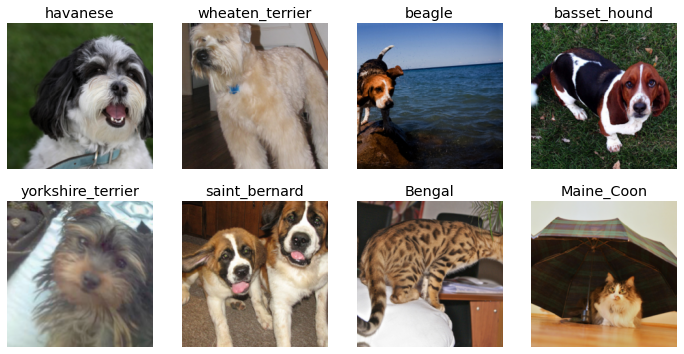

In [14]:
# By using show batch method 
dls.show_batch(nrows = 2 , ncols = 4)

Looking at all the images above we couldn't figure whether the labels are right up there. Well people who knows everything about Pet Breed's can answer this, but data scientists often work on data that are not as familiar as other domains. 

If we made a mistake while building a `DataBlock`, we won't likely see it before this step. We can use the `summary` method of `DataBlock` class, it creates a batch from the source (`path / 'images'`) we give it. 

It provides alot of details, if it fails we can figure at exactly which point the error happens like the library will help us.

For instance below, missing out the piece of code `Resize` and will see what's happening here. 

In [15]:
pets_error = DataBlock(blocks = (ImageBlock , CategoryBlock) , 
                 get_items = get_image_files , 
                 splitter = RandomSplitter(seed = 42) , 
                 get_y = using_attr(RegexLabeller(r'(.+)_\d+.jpg$') , 'name') , 
                 batch_tfms = aug_transforms(size = 224 , min_scale=0.75))

# Creating a dataloaders / with summary 
pets_error.summary(path/'images')

Setting-up type transforms pipelines
Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      /root/.fastai/data/oxford-iiit-pet/images/British_Shorthair_173.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=500x332
  Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      /root/.fastai/data/oxford-iiit-pet/images/British_Shorthair_173.jpg
    applying partial gives
      British_Shorthair
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(4)

Final sample: (PILImage mode=RGB size=500x332, TensorCategory(4))


Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}


RuntimeError: ignored